## Chapter 9. DEG and GO Analysis

Differential Gene Expression을 수행하고 이에 따라 Differential Gene Expression을 하는 유전자 목록을 불러내고, 
이를 이용하여 GO TERM Enrichment Analysis를 수행하자. 

일단 이를 위해서 sample.tsv를 수정하고 sleuth.R을 다시 실행한다. 

>sample,condition,path  
>SRR11308188,Control,./quant8188  
>SRR11308187,Control,./quant8187   
>SRR11308184,Control,./quant8184   
>SRR11308181,NaCl,./quant8181   
>SRR11308182,NaCl,./quant8182   
>SRR11308183,NaCl,./quant8183   

분석을 간단하게 하기 위하여 Control과 NaCl Treatment 2개 조건에 대해서만 Differential Expression을 수행한다. 
Control과 H2O2, Control과 NaCl+H2O2 조건에 대해서는 별도로 분석해 보도록 하자. 

sample.tsv를 수정하여 RStudio에서 Sleuth.R 을 수행하여 저장된 결과인 sleuth.csv 를 이용하여 분석을 수행한다. 

/Users/suknamgoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


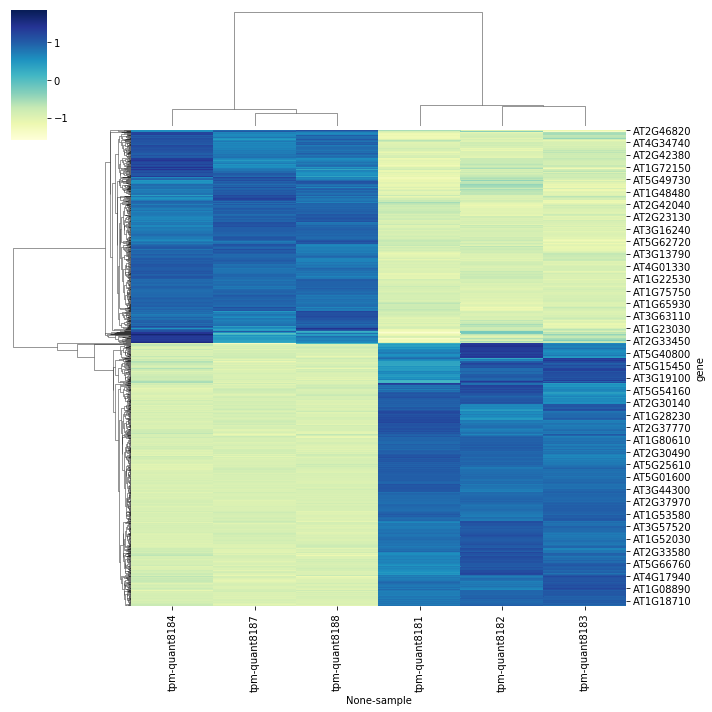

In [1]:
#8장의 코드를 모은 것 
# Kallisto Data에서 Differential Expression 되는 유전자 Top 1000 을 heatmap을 그리고 이를 clustered 로 저장
#


import pandas as pd
import seaborn as sns 

sleuth = pd.read_csv('sleuth.csv')

#샘플이 들어 있는 디렉토리 목록을 리스트로 만들고 
directorylist=['quant8188',
      'quant8187',
      'quant8184',
      'quant8181',
      'quant8182',
      'quant8183',
   ]

#각각의 디렉토리에 있는 abundance.tsv내용을 데이터프레임으로 읽어 abundances라는 딕셔너리에 넣는다. 
abundances = {}
for directory in directorylist:
    abundances[directory]=pd.read_csv('./'+directory+'/abundance.tsv',sep="\t")
    
ab = []
for key,values in abundances.items():
    temp = values[['target_id','tpm']]
    temp['sample']=key
    ab.append(temp)

est_counts = pd.concat(ab)
est_counts['gene']=est_counts['target_id'].str.split(r'\.|\_').str[0]
gene = est_counts.groupby(['gene','sample'])['tpm'].sum().reset_index()
matrix = gene.pivot(index='gene',columns='sample')
top1000 = matrix.loc[sleuth['target_id'][0:1000].to_list()]
g=sns.clustermap(top1000, z_score=0,cmap='YlGnBu')

row = g.dendrogram_row.reordered_ind
col = g.dendrogram_col.reordered_ind

t1000=top1000.to_numpy()
u = t1000[row,:][:,col]
index = top1000.index.to_numpy()[row]
gene = top1000.columns.to_numpy()[col]
clustered = pd.DataFrame(data=u, index=index,columns=gene)
clustered.to_excel('Nacl.xlsx')

클러스터링 된 expression 데이터의 원본은 clustered 라는 데이터프레임에 저장된다. 

In [2]:
clustered

,"(tpm, quant8184)","(tpm, quant8187)","(tpm, quant8188)","(tpm, quant8181)","(tpm, quant8182)","(tpm, quant8183)"
AT2G46820,991.225200,1080.349200,1028.101200,898.931800,838.835800,841.367110
AT3G61470,5092.860000,5608.000000,5519.270000,4316.380000,3851.100000,3804.410000
AT4G26530,272.026070,298.627170,309.358890,218.914350,195.941850,191.736270
AT3G53420,1359.663450,1417.624597,1458.632100,1156.599624,1086.352140,1048.394070
AT3G11280,64.821630,64.773490,65.135380,59.493320,60.619170,57.640020
...,...,...,...,...,...,...
AT1G45249,21.618182,16.819367,18.348401,71.126648,74.322134,75.386260
AT4G15440,36.760500,31.421300,35.089700,71.251700,75.707400,76.931100
AT3G61220,24.248690,18.046402,20.620450,58.454880,62.939900,64.461115
AT5G04760,37.772900,31.829800,32.897100,78.270100,78.627600,77.901200


TPM 값은 유전자마다 차이가 크고 몇몇 유전자의 발현값이 아주 높기 때문에 이를 그대로 그래프를 그리면 이렇게 잘 구분이 안 되는 데이터가 나온다. 


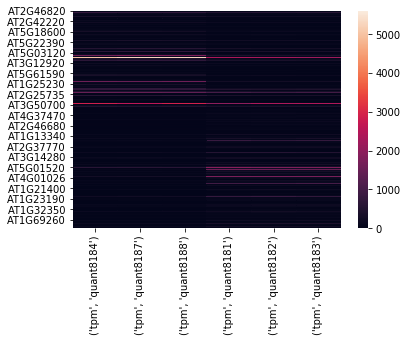

In [3]:
sns.heatmap(clustered)

Clustering 된 데이터는 각각의 Sample에서 평균이 되는 유전자의 발현값을 0 으로 하고,   
이를 표준편차로 나누어서 표준화된 데이터를 이용하연 차후의 분석이 좀 더 용이하다. 

유전자 간의 발현 차이가  많기 때문에 표준화를 수행하면 좀 더 용이하게 비교가 가능하다.  
TPM 값을 별도로 표준화하기 위해서는 다음 명령을 수행한다. 

In [4]:
from sklearn import preprocessing 
scaled = preprocessing.scale(clustered,axis=1)
scaled

array([[ 0.48317822,  1.44532835,  0.88127804, -0.5131876 , -1.16196205,
        -1.13463495],
       [ 0.52993245,  1.22246499,  1.10318011, -0.51393459, -1.13943745,
        -1.20220552],
       [ 0.50903601,  1.06722558,  1.29241679, -0.60544451, -1.08749261,
        -1.17574125],
       ...,
       [-0.83366088, -1.13404662, -1.00938178,  0.82299422,  1.04021021,
         1.11388485],
       [-0.83354675, -1.10214209, -1.05390602,  0.99670336,  1.01286039,
         0.98003111],
       [-0.83335961, -1.03909408, -1.11303114,  0.90766259,  1.08599048,
         0.99183175]])

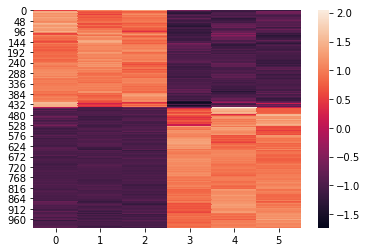

In [5]:
#Heatmap을 그리면 이전에 clustermap 기능에서 z_score=0 의 옵션을 준 것과 동일한 heatmap이 나온다. 
sns.heatmap(scaled)

위의 Clustered Heatmap 을 보면 처리군에서 Expression이 내려가는 그룹과  
처리군에서 Expression이 내려가는 그룹이 존재한다. 

각각의 유전자 이름ㅇ르 어떻게 얻을 수 있을까? 

이를 위하여 표준화된 유전자에 대해서 별도로 Hierarchical Clustering을 수행하고 유전자들을 분리하도록 한다. 

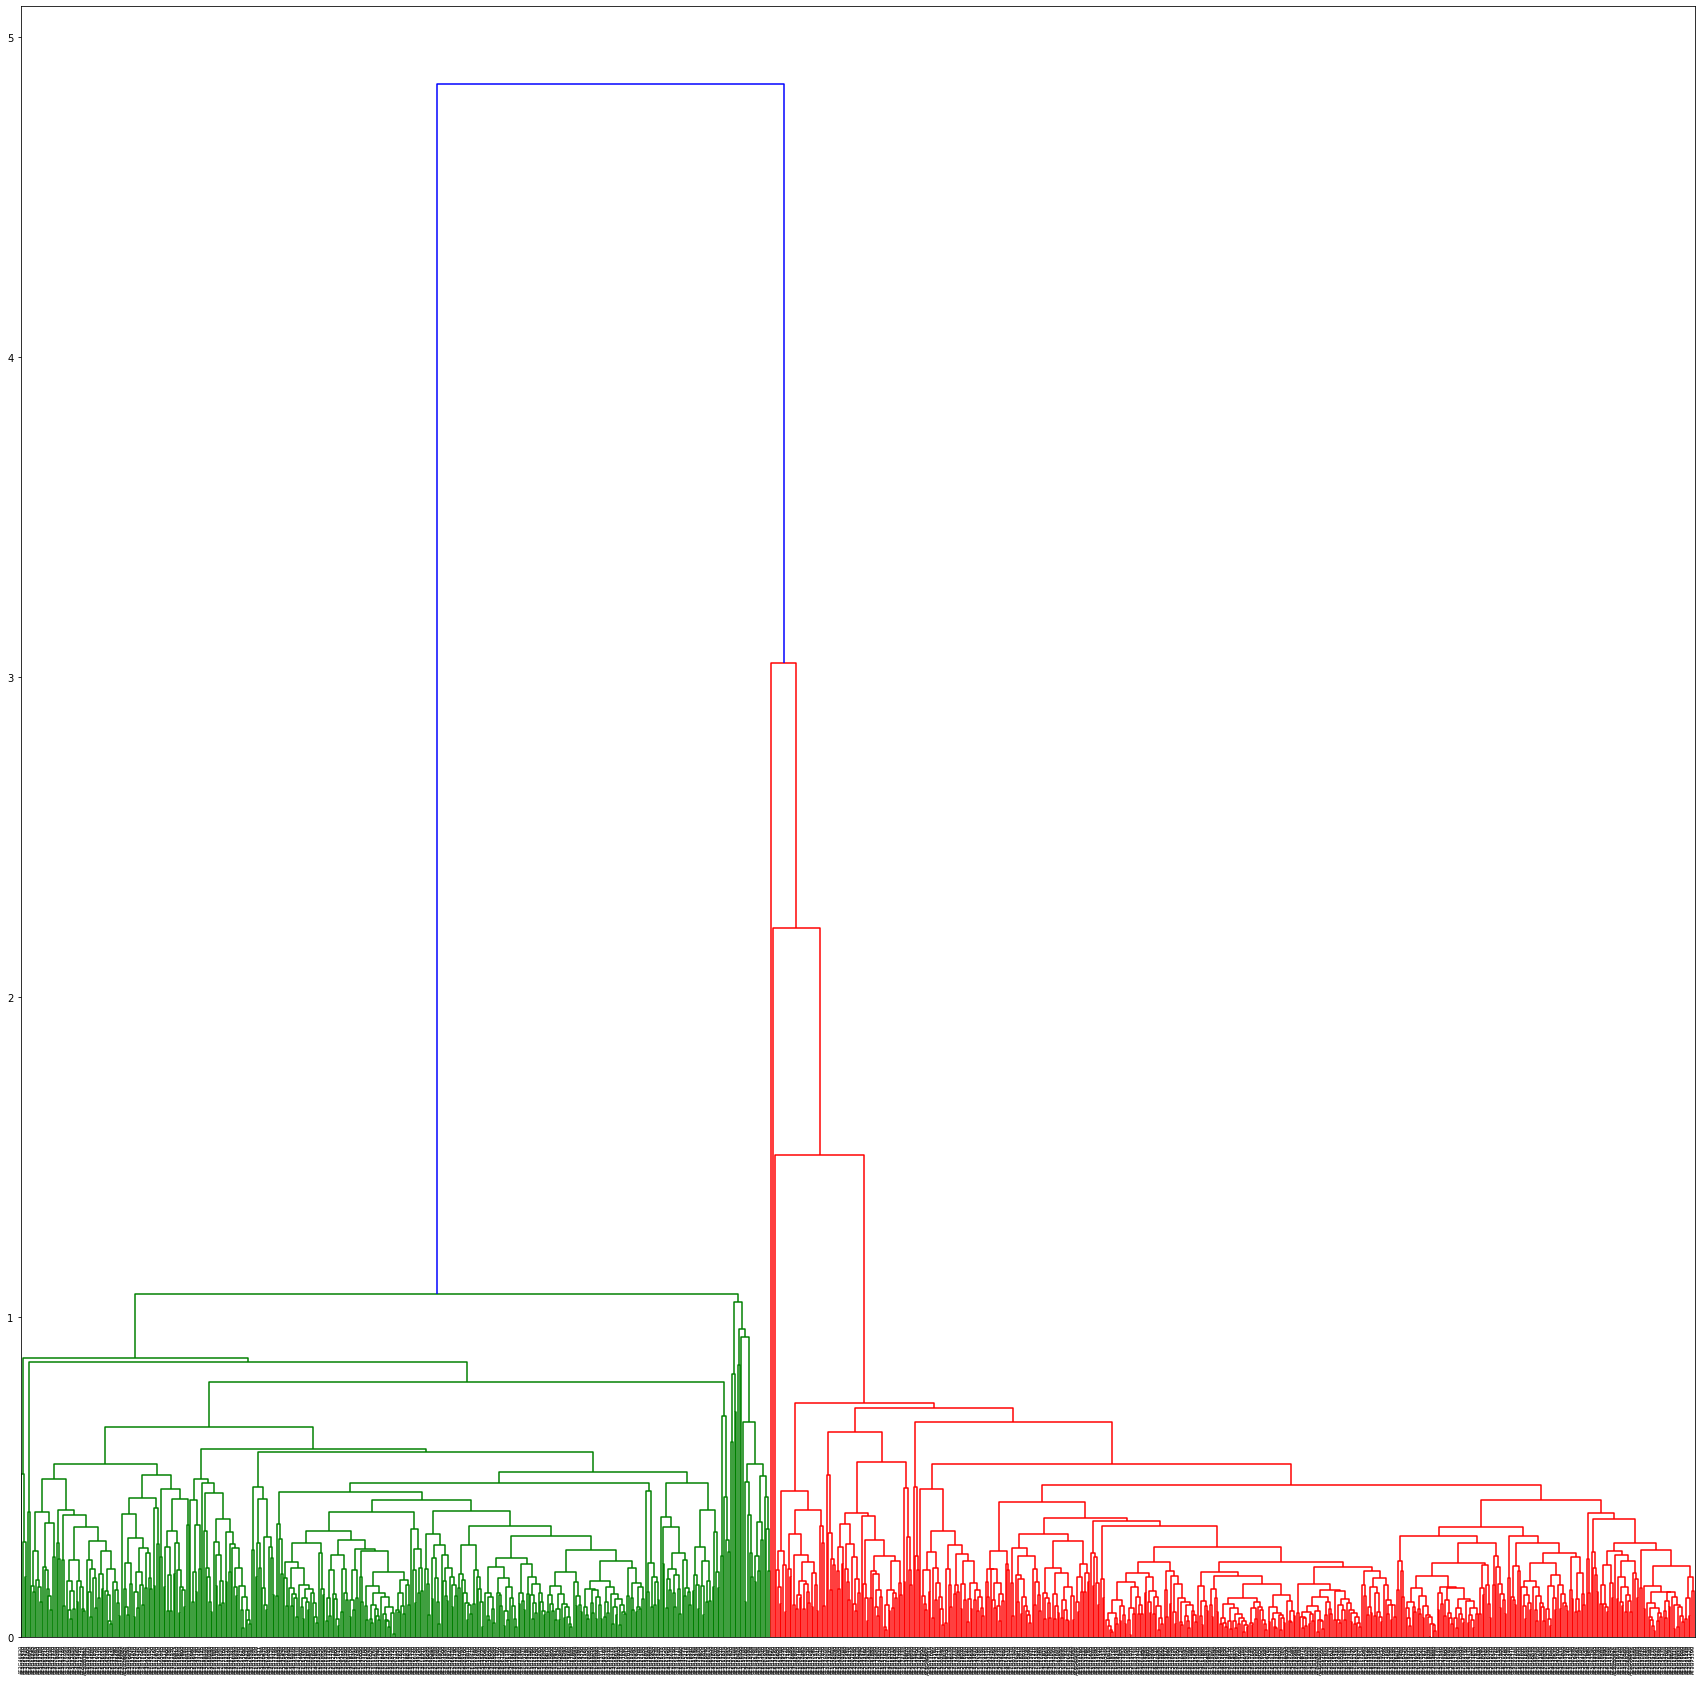

In [6]:
#
# Clustered 된 유전자를 Hierichial Clustering을 이용하여 반으로 나누고, 유전자의 이름을 얻는다. 
#

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

d = sch.linkage(scaled,method='average')
plt.figure(figsize=(30,30))
sch.dendrogram(d,
               labels=clustered.index.to_numpy())
plt.savefig('Genes.pdf')



In [7]:
#트리를 나눌 기준값을 4로 정한다. 
assignments=sch.fcluster(d,4,'distance')
assignments

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

왼쪽의 그룹 (Control보다 NaCl 군에서 Expression이 낮아진 그룹)에는 '1'이 지정되었고,  
오른쪽 그룹 (NaCl에서 Expression이 많이 된 그룹)에는 '2'가 지정되었다.   

이 값을 Expression 데이터에 넣어본다. 

In [8]:
cluster_output = pd.DataFrame({'name':clustered.index.to_numpy(),'cluster':assignments})
cluster_output

,name,cluster
0,AT2G46820,1
1,AT3G61470,1
2,AT4G26530,1
3,AT3G53420,1
4,AT3G11280,1
...,...,...
995,AT1G45249,2
996,AT4G15440,2
997,AT3G61220,2
998,AT5G04760,2


In [9]:
#각각의 Group의 멤버 숫자 

cluster_output.groupby(['cluster']).count()

,name
cluster,
1,448
2,552


In [10]:
underexpressed = cluster_output[cluster_output['cluster']==1]
overexpressed = cluster_output[cluster_output['cluster']==2]

In [11]:
overexpressed

,name,cluster
448,AT5G14420,2
449,AT2G21660,2
450,AT2G42750,2
451,AT4G35560,2
452,AT1G72680,2
...,...,...
995,AT1G45249,2
996,AT4G15440,2
997,AT3G61220,2
998,AT5G04760,2


유전자 이름 만으로 어떻게 정보를 추출할 것인가? 
유전자 이름과 연관된 GO Term 을 불러오자. 
https://www.arabidopsis.org/download/index-auto.jsp?dir=%2Fdownload_files%2FGO_and_PO_Annotations%2FGene_Ontology_Annotations

https://www.arabidopsis.org/download_files/GO_and_PO_Annotations/Gene_Ontology_Annotations/ATH_GO_GOSLIM.txt

In [12]:
import pandas as pd 
goslim = pd.read_csv('ATH_GO_GOSLIM.txt',skiprows=4,sep="\t",header=None)
goslim

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,AT1G01010,locus:2200935,AT1G01010,involved in,"regulation of transcription, DNA-templated",GO:0006355,7461,P,other cellular processes,ISS,none,NaN,Publication:1345963|PMID:11118137,NaN,2018-04-02
1,AT1G01010,locus:2200935,AT1G01010,functions in,transcription regulatory region DNA binding,GO:0044212,33424,F,DNA binding,IPI,yeast one-hybrid assay,AGI_LocusCode:AT2G38290,Publication:501786139|PMID:30356219,sibrady,2019-08-30
2,AT1G01010,locus:2200935,AT1G01010,involved in,"regulation of transcription, DNA-templated",GO:0006355,7461,P,other metabolic processes,IEA,none,InterPro:IPR003441|InterPro:IPR036093,AnalysisReference:501756966,NaN,2020-04-23
3,AT1G01010,locus:2200935,AT1G01010,involved in,"regulation of transcription, DNA-templated",GO:0006355,7461,P,biosynthetic process,IEA,none,InterPro:IPR003441|InterPro:IPR036093,AnalysisReference:501756966,NaN,2020-04-23
4,AT1G01010,gene:2200934,AT1G01010.1,located in,nucleus,GO:0005634,537,C,nucleus,ISM,predicted protein features,NaN,AnalysisReference:501780126,rkaundal,2018-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339253,YAK,gene:1945468,YAK,involved in,biological_process,GO:0008150,5239,P,unknown biological processes,ND,'Unknown' biological process,NaN,Communication:1345790,TAIR,2006-10-19
339254,YAK,gene:1945468,YAK,has,molecular_function,GO:0003674,3226,F,unknown molecular functions,ND,'Unknown' molecular function,NaN,Communication:1345790,TAIR,2006-10-20
339255,YI,gene:1945470,YI,located in,cellular_component,GO:0005575,163,C,unknown cellular components,ND,'Unknown' cellular component,NaN,Communication:1345790,TAIR,2006-10-19
339256,YI,gene:1945470,YI,involved in,biological_process,GO:0008150,5239,P,unknown biological processes,ND,'Unknown' biological process,NaN,Communication:1345790,TAIR,2006-10-19


Go Term에서 필요한 컬럼만 추린다. 

In [13]:
GO = goslim[[0,1,2,4,5,8]]
GO.columns=['gene','locus','transcripts','description','goterm','process']
GO

,gene,locus,transcripts,description,goterm,process
0,AT1G01010,locus:2200935,AT1G01010,"regulation of transcription, DNA-templated",GO:0006355,other cellular processes
1,AT1G01010,locus:2200935,AT1G01010,transcription regulatory region DNA binding,GO:0044212,DNA binding
2,AT1G01010,locus:2200935,AT1G01010,"regulation of transcription, DNA-templated",GO:0006355,other metabolic processes
3,AT1G01010,locus:2200935,AT1G01010,"regulation of transcription, DNA-templated",GO:0006355,biosynthetic process
4,AT1G01010,gene:2200934,AT1G01010.1,nucleus,GO:0005634,nucleus
...,...,...,...,...,...,...
339253,YAK,gene:1945468,YAK,biological_process,GO:0008150,unknown biological processes
339254,YAK,gene:1945468,YAK,molecular_function,GO:0003674,unknown molecular functions
339255,YI,gene:1945470,YI,cellular_component,GO:0005575,unknown cellular components
339256,YI,gene:1945470,YI,biological_process,GO:0008150,unknown biological processes


GO TERM에서 'transcription'에 대한 것들이 들어있는 것만 뽑아보자. 

In [14]:
Transcription = GO[GO['description'].str.contains('transcription')]
Transcription

,gene,locus,transcripts,description,goterm,process
0,AT1G01010,locus:2200935,AT1G01010,"regulation of transcription, DNA-templated",GO:0006355,other cellular processes
1,AT1G01010,locus:2200935,AT1G01010,transcription regulatory region DNA binding,GO:0044212,DNA binding
2,AT1G01010,locus:2200935,AT1G01010,"regulation of transcription, DNA-templated",GO:0006355,other metabolic processes
3,AT1G01010,locus:2200935,AT1G01010,"regulation of transcription, DNA-templated",GO:0006355,biosynthetic process
5,AT1G01010,locus:2200935,AT1G01010,"regulation of transcription, DNA-templated",GO:0006355,nucleobase-containing compound metabolic process
...,...,...,...,...,...,...
332168,CUE9,gene:3715180,CUE9,"positive regulation of transcription, DNA-temp...",GO:0045893,biosynthetic process
337466,HCF5,gene:3715304,HCF5,"regulation of transcription, DNA-templated",GO:0006355,biosynthetic process
337468,HCF5,gene:3715304,HCF5,"regulation of transcription, DNA-templated",GO:0006355,other metabolic processes
337469,HCF5,gene:3715304,HCF5,"regulation of transcription, DNA-templated",GO:0006355,other cellular processes


NaCl 처리후 과발현된 유전자 중에서 'Transcription'이라는 GO-TERM과 연관이 있는 유전자의 공통부분을 찾으면

In [15]:
TR = pd.merge(overexpressed,Transcription, left_on='name',right_on='gene',how='inner')
TR

,name,cluster,gene,locus,transcripts,description,goterm,process
0,AT5G25220,2,AT5G25220,locus:2146945,AT5G25220,regulation of transcription by RNA polymerase II,GO:0006357,biosynthetic process
1,AT5G25220,2,AT5G25220,locus:2146945,AT5G25220,DNA-binding transcription factor activity,GO:0003700,DNA-binding transcription factor activity
2,AT5G25220,2,AT5G25220,locus:2146945,AT5G25220,regulation of transcription by RNA polymerase II,GO:0006357,other cellular processes
3,AT5G25220,2,AT5G25220,locus:2146945,AT5G25220,"regulation of transcription, DNA-templated",GO:0006355,other cellular processes
4,AT5G25220,2,AT5G25220,locus:2146945,AT5G25220,"regulation of transcription, DNA-templated",GO:0006355,other metabolic processes
...,...,...,...,...,...,...,...,...
578,AT5G04760,2,AT5G04760,locus:2175478,AT5G04760,"regulation of transcription, DNA-templated",GO:0006355,other metabolic processes
579,AT5G04760,2,AT5G04760,locus:2175478,AT5G04760,"regulation of transcription, DNA-templated",GO:0006355,nucleobase-containing compound metabolic process
580,AT5G04760,2,AT5G04760,locus:2175478,AT5G04760,DNA-binding transcription factor activity,GO:0003700,DNA-binding transcription factor activity
581,AT5G04760,2,AT5G04760,locus:2175478,AT5G04760,"regulation of transcription, DNA-templated",GO:0006355,other cellular processes


한 유전자에 여러 GO TERM이 존재하므로, 유전자가 중복되어 있다.   
여기서 고유한 유전자들만 골라내 보자. 

In [16]:
#'gene'컬럼에서 'unique()'를 이용하여 고유한 유전자 목록을 찾을 수 있다. 

transcription = TR['gene'].unique()
transcription

array(['AT5G25220', 'AT3G12145', 'AT5G40800', 'AT1G48000', 'AT3G19290',
       'AT1G69490', 'AT3G24520', 'AT3G56400', 'AT5G24120', 'AT2G46680',
       'AT2G35940', 'AT1G30500', 'AT5G59820', 'AT3G49530', 'AT4G25470',
       'AT1G53170', 'AT1G01720', 'AT1G53910', 'AT2G19810', 'AT4G29190',
       'AT1G28370', 'AT2G22900', 'AT3G27250', 'AT5G24780', 'AT4G16750',
       'AT1G27730', 'AT5G47640', 'AT1G77450', 'AT2G41180', 'AT3G29575',
       'AT4G27410', 'AT5G22290', 'AT1G51140', 'AT5G04340', 'AT5G22380',
       'AT5G39610', 'AT3G55980', 'AT3G19580', 'AT4G34000', 'AT1G19490',
       'AT2G34720', 'AT5G63790', 'AT1G52890', 'AT1G43160', 'AT1G69260',
       'AT2G18050', 'AT5G24660', 'AT1G56170', 'AT3G56290', 'AT1G18710',
       'AT5G50360', 'AT1G45249', 'AT5G04760'], dtype=object)

In [17]:
#이번에는 'ubiquitin'이 GO TERM에 들어있는 유전자를 찾으면 

UB = GO[GO['description'].str.contains('ubiquitin')]
UBI = pd.merge(overexpressed,UB, left_on='name',right_on='gene',how='inner')

In [18]:
UBI['gene'].unique()

array(['AT5G14420', 'AT4G35560', 'AT2G33770', 'AT1G55760', 'AT3G52850',
       'AT3G12580', 'AT1G21410', 'AT1G33480', 'AT3G17000', 'AT5G57900',
       'AT5G01520', 'AT3G13672', 'AT4G22820', 'AT3G61060', 'AT1G78070',
       'AT1G60190', 'AT1G80110', 'AT5G10380', 'AT5G28540', 'AT5G42020',
       'AT3G53230', 'AT4G20110'], dtype=object)

5,6장의 Genome cDNA, protein fasta file에서 유전자의 설명을 추출해오는 코드를 이용하여 Arabidopsis의 유전자 별 설명을 추출하자. 

In [19]:
#5,6장의 내용을 합쳐서 DNA와 Protein file을 넣으면 데이터프레임화하는 함수를 만듬
import pandas as pd
from pyfaidx import Fasta

def MolWeight(proteinsequence):
# 분자량을 구하는 함수 
# proteinsequence 에 아미노산 서열을 받고 
# MW 에는 각각의 아미노산과 분자량의 딕셔너리가 있다. 
    MW = {'G':57.05,
          'A':71.09,
          'S':87.08,
          'T':101.11,
          'C':103.15,
          'V':99.14,
          'L':113.16,
          'I':113.16,
          'M':131.19,
          'P':97.12,
          'F':147.18,
          'Y':163.18,
          'W':186.21,
          'D':115.09,
          'E':129.12,
          'N':114.11,
          'Q':128.14,
          'H':137.14,
          'K':128.17,
          'R':156.19,
          'X':0,
          'J':0}
    MolecularWeight=0
    for aa in proteinsequence:
        MolecularWeight=MolecularWeight+MW[aa]
    return(MolecularWeight)

def mid_extract (original, search1, search2):
    if (search1 in original) & (search2 in original):
        return(original.split(search1)[1].split(search2)[0])
    else:
        return('') 


#5강에서 했던 단백질 서열에서부터 정보 추출 
def DNAProtein(Proteinfile,DNAfile):
   
    AraProtein= Fasta(Proteinfile)
    proteinkey = []
    proteindescription = []
    proteinsequence = []

    for protein in AraProtein.keys():
        proteinkey.append(protein)
        proteindescription.append(AraProtein[protein].long_name.split(protein+' ')[1].split(' [')[0])
        proteinsequence.append(str(AraProtein[protein]))

    proteins = pd.DataFrame(data={'key':proteinkey,'description':proteindescription,'sequence':proteinsequence})
    AraSequence= Fasta(DNAfile)

    #5강에서 했던 DNA CDS 시퀀스 설명으로부터 정보 추출

    DNAsequence = []
    DNAproteinid = []
    DNAlocusid = []

    for Sequence in AraSequence.keys():
        name = AraSequence[Sequence].long_name
        DNAsequence.append(str(AraSequence[Sequence]))
        DNAproteinid.append(mid_extract(name,'[protein_id=',']'))
        DNAlocusid.append(mid_extract(name,'[locus_tag=',']'))

    DNASeq = pd.DataFrame(data={'protein':DNAproteinid,'sequence':DNAsequence, 'locus':DNAlocusid})

    #이 내용을 DNAprotein 이라는 데이터프레임으로 저장 
    DNAprotein = pd.merge(DNASeq,proteins, left_on='protein',right_on='key', how='left')
    DNAprotein['MW']=DNAprotein['sequence_y'].apply(MolWeight)
    return(DNAprotein)
    
#5,6장의 내용을 합쳐서 DNA와 Protein file을 넣으면 데이터프레임화하는 함수를 만듬    
Arabidopsis = DNAProtein('GCA_000001735.2_TAIR10.1_protein.faa','GCA_000001735.2_TAIR10.1_cds_from_genomic.fna')



In [20]:
overexpressTR = Arabidopsis[Arabidopsis['locus'].isin(transcription)][['locus','description']].drop_duplicates()

In [21]:
overexpressTR

,locus,description
164,AT1G01720,NAC (No Apical Meristem) domain transcriptiona...
3564,AT1G18710,myb domain protein 47
3702,AT1G19490,Basic-leucine zipper (bZIP) transcription fact...
5058,AT1G27730,salt tolerance zinc finger
5171,AT1G28370,ERF domain protein 11
5516,AT1G30500,"nuclear factor Y, subunit A7"
6497,AT1G43160,related to AP2 6
6697,AT1G45249,abscisic acid responsive elements-binding fact...
6853,AT1G48000,myb domain protein 112
7402,AT1G51140,basic helix-loop-helix (bHLH) DNA-binding supe...


In [24]:
TPM=clustered.loc[overexpressTR['locus'].to_list()]
TPM.reset_index(inplace=True)
TPM

,index,"(tpm, quant8184)","(tpm, quant8187)","(tpm, quant8188)","(tpm, quant8181)","(tpm, quant8182)","(tpm, quant8183)"
0,AT1G01720,55.031100,55.761800,61.017600,107.656300,95.966400,99.360700
1,AT1G18710,30.988830,31.388753,29.842960,70.105140,72.099910,73.540330
2,AT1G19490,2.763140,2.411290,2.310620,8.493450,11.096000,10.051600
3,AT1G27730,34.204100,32.698700,33.714200,92.124100,88.587900,80.847900
4,AT1G28370,11.578400,10.891500,7.532890,33.866500,35.163300,31.830000
5,AT1G30500,12.801237,13.507735,17.040404,43.380222,45.069814,39.024550
6,AT1G43160,14.127500,13.858400,13.927800,38.396500,38.934700,44.528400
7,AT1G45249,21.618182,16.819367,18.348401,71.126648,74.322134,75.386260
8,AT1G48000,2.225030,1.749010,1.473540,17.084500,17.734500,25.585800
9,AT1G51140,31.032500,28.139400,28.345500,125.071210,122.755000,132.431422


In [26]:
datanew=pd.merge(TPM,overexpressTR, left_on='index',right_on='locus',how='inner')

In [27]:
datanew=datanew.drop(columns=['index','locus']).set_index('description')

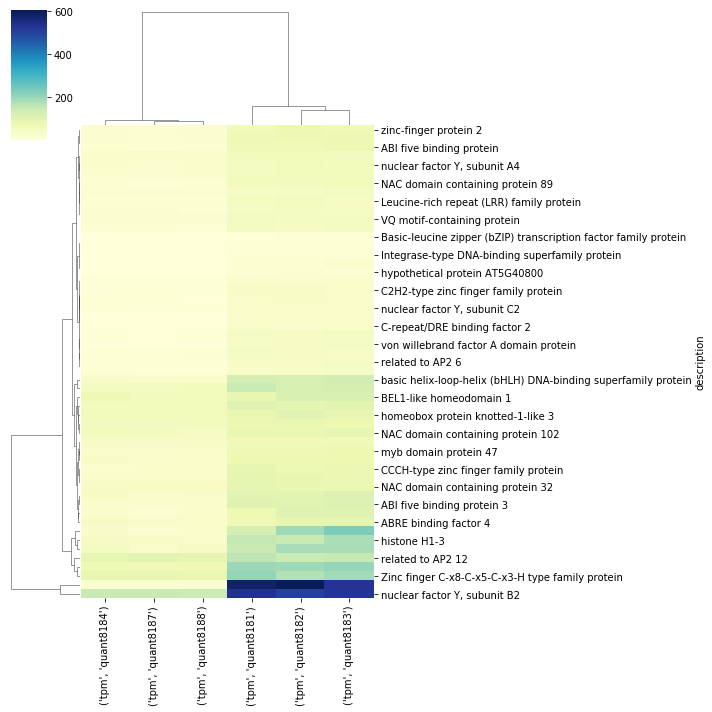

In [28]:
import seaborn as sns
g=sns.clustermap(datanew, cmap='YlGnBu')

In [29]:
UB = GO[GO['description'].str.contains('ubiquitin')]
UBI = pd.merge(overexpressed,UB, left_on='name',right_on='gene',how='inner')
ubiquitingenes = UBI['gene'].unique()
OverexpressUBI = Arabidopsis[Arabidopsis['locus'].isin(ubiquitingenes)][['locus','description']].drop_duplicates()

In [30]:
OverexpressUBI

,locus,description
4039,AT1G21410,F-box/RNI-like superfamily protein
6015,AT1G33480,RING/U-box superfamily protein
8301,AT1G55760,BTB/POZ domain-containing protein
8807,AT1G60190,ARM repeat superfamily protein
12046,AT1G78070,Transducin/WD40 repeat-like superfamily protein
12467,AT1G80110,phloem protein 2-B11
17438,AT2G33770,phosphate 2
22505,AT3G12580,heat shock protein 70
22735,AT3G13672,TRAF-like superfamily protein
23424,AT3G17000,ubiquitin-conjugating enzyme 32


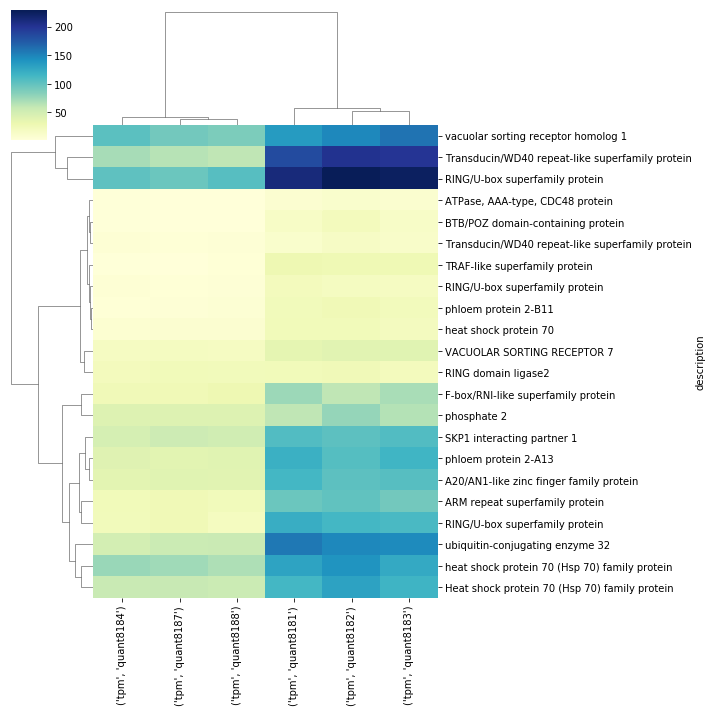

In [31]:
TPM=clustered.loc[OverexpressUBI['locus'].to_list()]
TPM.reset_index(inplace=True)
datanew=pd.merge(TPM,OverexpressUBI, left_on='index',right_on='locus',how='inner')
datanew=datanew.drop(columns=['index','locus']).set_index('description')
g=sns.clustermap(datanew, cmap='YlGnBu')

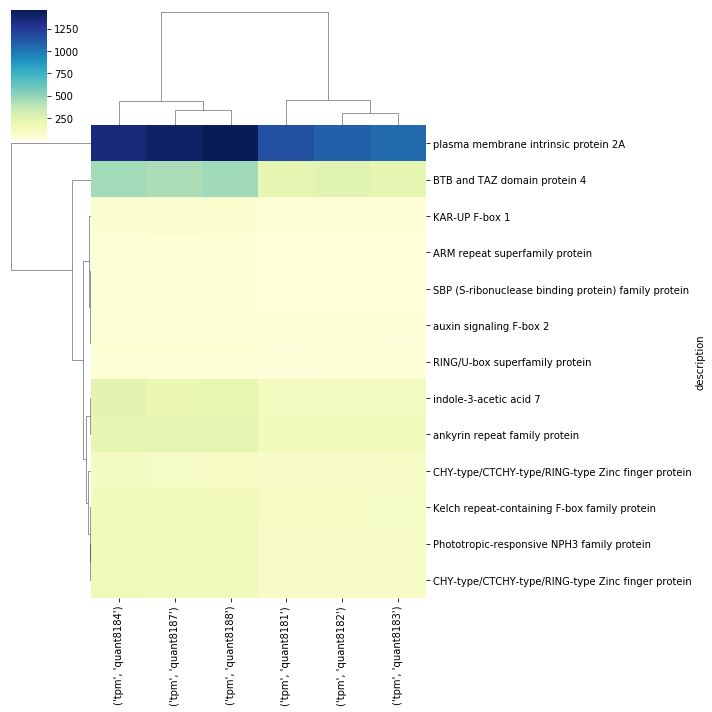

In [32]:
underexpressed = cluster_output[cluster_output['cluster']==1]
UB = GO[GO['description'].str.contains('ubiquitin')]
UBI = pd.merge(underexpressed, UB, left_on='name',right_on='gene',how='inner')
ubiquitingenes = UBI['gene'].unique()
UnderexpressUBI = Arabidopsis[Arabidopsis['locus'].isin(ubiquitingenes)][['locus','description']].drop_duplicates()
TPM=clustered.loc[UnderexpressUBI['locus'].to_list()]
TPM.reset_index(inplace=True)
datanew=pd.merge(TPM,UnderexpressUBI, left_on='index',right_on='locus',how='inner')
datanew=datanew.drop(columns=['index','locus']).set_index('description')
g=sns.clustermap(datanew, cmap='YlGnBu')

In [34]:
#그렇다면 Overexpression 된 유전자와 Underexpression 된 유전자에서 전체적으로 많이 나타나는 유전자들은 어떤 종류의 것들인가? 
#이를 위해서 Overexpression 된 그룹의 유전자와 연결된 Go Term 은 어떤 것들인지 알아보자. 

#이를 위해서 일단 Overexpression 된 유전자의 목록을 뽑아보자. 
overexpressed

,name,cluster
448,AT5G14420,2
449,AT2G21660,2
450,AT2G42750,2
451,AT4G35560,2
452,AT1G72680,2
...,...,...
995,AT1G45249,2
996,AT4G15440,2
997,AT3G61220,2
998,AT5G04760,2


유전자의 형식을 https://www.arabidopsis.org/tools/go_term_enrichment.jsp 에서 사용하는 형식으로 바꾸낟. 

In [35]:
genelist = overexpressed['name'].str.replace('AT','At').str.replace('G','g').to_list()
for gene in genelist:
    print(gene)

At5g14420
At2g21660
At2g42750
At4g35560
At1g72680
At3g19620
At3g62700
At3g49590
At2g33770
At5g25220
At1g27100
At4g37430
At5g24380
At4g36988
At3g16510
At2g43800
At2g05710
At1g55760
At2g04160
At3g12145
At5g40800
At5g62530
At5g24150
At3g15730
At3g53980
At3g57540
At5g20280
At1g21310
At5g23010
At5g22740
At3g15020
At5g07030
At4g37470
At2g29300
At3g49580
At2g23120
At1g73540
At1g48000
At3g26290
At2g04030
At3g19290
At5g42050
At3g03640
At5g03760
At2g18660
At5g47180
At5g15450
At4g36210
At1g54575
At4g02280
At1g54570
At4g30490
At3g28270
At1g69490
At3g52850
At2g41475
At5g22460
At2g33380
At1g79270
At3g24520
At3g03890
At1g41880
At3g50970
At2g41190
At1g79900
At2g43510
At1g29640
At5g52310
At5g57050
At4g23670
At1g20450
At4g13250
At3g19100
At5g58710
At1g52690
At3g56400
At5g24120
At1g67920
At5g63130
At1g72770
At2g46680
At5g50920
At1g49670
At2g35940
At4g00630
At1g48750
At4g15610
At1g49450
At4g37390
At3g26170
At4g39955
At1g28290
At2g42840
At5g45800
At3g06860
At3g27210
At5g17050
At3g14067
At5g54160
At5g13420


웹에서 'Export Table'을 선택하여 결과를 analysis.txt로 다운로드받자

In [42]:
!head -n 20 analysis.txt






Analysis Type:	PANTHER Overrepresentation Test (Released 20200407)
Annotation Version and Release Date:	GO Ontology database DOI:  10.5281/zenodo.3727280 Released 2020-03-23
Analyzed List:	upload_1 (Arabidopsis thaliana)
Reference List:	Arabidopsis thaliana (all genes in database)
Test Type:	FISHER
Correction:	BONFERRONI
Bonferroni count:	2822
GO biological process complete	Arabidopsis thaliana - REFLIST (27416)	upload_1 (538)	upload_1 (expected)	upload_1 (over/under)	upload_1 (fold Enrichment)	upload_1 (P-value)
proline metabolic process (GO:0006560)	12	6	.24	+	25.48	2.13E-03
monovalent inorganic anion homeostasis (GO:0055083)	19	7	.37	+	18.77	1.27E-03
divalent inorganic anion homeostasis (GO:0072505)	19	7	.37	+	18.77	1.27E-03
phosphate ion homeostasis (GO:0055062)	17	6	.33	+	17.99	1.07E-02
trivalent inorganic anion homeostasis (GO:0072506)	17	6	.33	+	17.99	1.07E-02
response to desiccation (GO:0009269)	24	7	.47	+	14.86	4.68E-03
response to insect (GO:0009625)	31	7	.61	+	11.51	2.0

In [48]:
import pandas as pd

#앞에서 12줄은 생략하고 값을 읽어온다. 
data = pd.read_csv('analysis.txt',skiprows=12, sep="\t")

In [92]:
data

,GO biological process complete,Arabidopsis thaliana - REFLIST (27416),upload_1 (538),upload_1 (expected),upload_1 (over/under),upload_1 (fold Enrichment),upload_1 (P-value)
0,proline metabolic process (GO:0006560),12,6,0.24,+,25.48,2.130000e-03
1,monovalent inorganic anion homeostasis (GO:005...,19,7,0.37,+,18.77,1.270000e-03
2,divalent inorganic anion homeostasis (GO:0072505),19,7,0.37,+,18.77,1.270000e-03
3,phosphate ion homeostasis (GO:0055062),17,6,0.33,+,17.99,1.070000e-02
4,trivalent inorganic anion homeostasis (GO:0072...,17,6,0.33,+,17.99,1.070000e-02
...,...,...,...,...,...,...,...
107,Unclassified (UNCLASSIFIED),4383,51,86.01,-,0.59,0.000000e+00
108,nucleobase-containing compound metabolic proce...,2168,10,42.54,-,0.24,4.990000e-06
109,gene expression (GO:0010467),1655,7,32.48,-,0.22,2.690000e-04
110,RNA metabolic process (GO:0016070),1348,3,26.45,-,0.11,5.400000e-05


In [56]:
#가장 많이 분포되는 GO TERM에 대한 결과를 불러오자. 

Proline = GO[GO['goterm']=='GO:0006560']

In [61]:
#Overexpressed 내에 존재하는 유전자는? 

pd.merge(overexpressed, Proline,left_on='name',right_on='gene',how='inner')[['name']]

,name
0,AT5G62530
1,AT5G62530
2,AT4G08870
3,AT4G08870


In [65]:
Arabidopsis[(Arabidopsis['locus']=='AT5G62530') | (Arabidopsis['locus']=='AT4G08870')]

,protein,sequence_x,locus,key,description,sequence_y,MW
30926,AEE82684.1,ATGTGGAAGATTGGGCAGAGAGGAGTTCCCTATTTCCAGAGACTCA...,AT4G08870,AEE82684.1,Arginase/deacetylase superfamily protein,MWKIGQRGVPYFQRLIAAPFTTLRSLPTSLVETGQNRVIDASLTLI...,37963.38
30927,AEE82685.1,ATGTGGAAGATTGGGCAGAGAGGAGTTCCCTATTTCCAGAGACTCA...,AT4G08870,AEE82685.1,Arginase/deacetylase superfamily protein,MWKIGQRGVPYFQRLIAAPFTTLRSLPTSLVETGQNRVIDASLTLI...,29296.35
47135,AED97619.1,ATGTATAGAGTTTTTGCGAGCCGAGCACTGAGAGCTAAGTCTCTCT...,AT5G62530,AED97619.1,aldehyde dehydrogenase 12A1,MYRVFASRALRAKSLCDKSSTSLASLTLSRLNHSIPFATVDAEELS...,61756.61


,index,"(tpm, quant8184)","(tpm, quant8187)","(tpm, quant8188)","(tpm, quant8181)","(tpm, quant8182)","(tpm, quant8183)"


/Users/suknamgoong/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


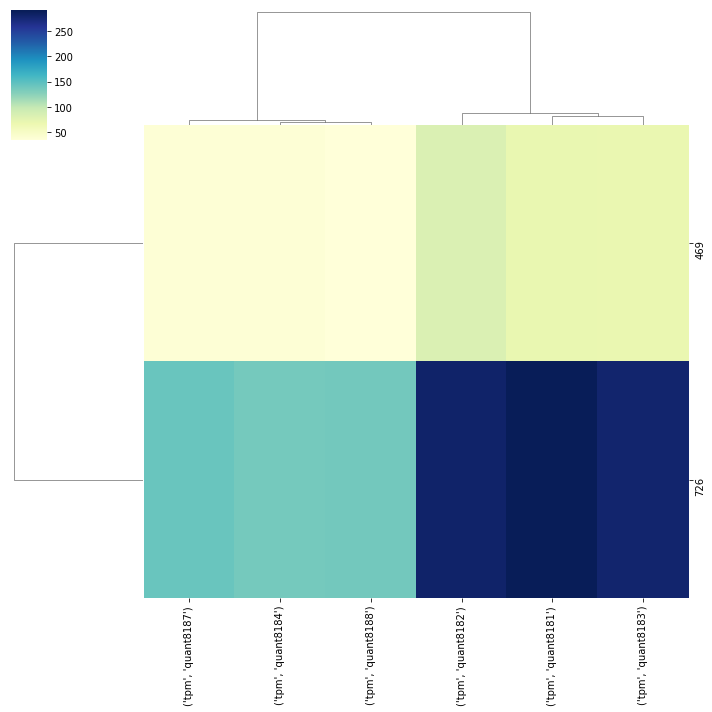

In [90]:
TPM = clustered.reset_index()
subgene = TPM[TPM['index'].isin(['AT5G62530','AT4G08870'])]
subgene.drop(columns='index',inplace=True)
g=sns.clustermap(subgene, cmap='YlGnBu')

In [101]:
#가장 많이 분포한 Go Term을 추출해 냄. 

Top10_Goterm=data[0:10]['GO biological process complete'].str.split('(').str[1].str.replace('\)','').to_list()
Top10_Goterm

['GO:0006560',
 'GO:0055083',
 'GO:0072505',
 'GO:0055062',
 'GO:0072506',
 'GO:0009269',
 'GO:0009625',
 'GO:0055081',
 'GO:0042538',
 'GO:0006972']

In [102]:
GO[GO['goterm'].isin(Top10_Goterm)]

,gene,locus,transcripts,description,goterm,process
792,AT1G01470,locus:2025346,AT1G01470,response to desiccation,GO:0009269,response to chemical
796,AT1G01470,locus:2025346,AT1G01470,response to desiccation,GO:0009269,response to stress
800,AT1G01470,locus:2025346,AT1G01470,response to desiccation,GO:0009269,response to abiotic stimulus
6093,AT1G05260,locus:2207210,AT1G05260,hyperosmotic salinity response,GO:0042538,response to abiotic stimulus
6096,AT1G05260,locus:2207210,AT1G05260,response to desiccation,GO:0009269,response to abiotic stimulus
...,...,...,...,...,...,...
331725,AT4G16730-WS,locus:6530257596,AT4G16730-WS,response to insect,GO:0009625,response to external stimulus
337479,HRL1,gene:1009022992,HRL1,response to insect,GO:0009625,response to biotic stimulus
337480,HRL1,gene:1009022992,HRL1,response to insect,GO:0009625,response to external stimulus
337859,MAM2,gene:1005964073,MAM2,response to insect,GO:0009625,response to biotic stimulus


In [106]:
TopGoterm = GO[GO['goterm'].isin(Top10_Goterm)]['gene'].unique()
TopGoterm

array(['AT1G01470', 'AT1G05260', 'AT1G06390', 'AT1G07640', 'AT1G14040',
       'AT1G14920', 'AT1G16410', 'AT1G16670', 'AT1G16920', 'AT1G17860',
       'AT1G18260', 'AT1G18570', 'AT1G19120', 'AT1G30560', 'AT1G32640',
       'AT1G44170', 'AT1G48130', 'AT1G48605', 'AT1G52330', 'AT1G52400',
       'AT1G53165', 'AT1G54100', 'AT1G57870', 'AT1G63010', 'AT1G64280',
       'AT1G66340', 'AT1G66350', 'AT1G68320', 'AT1G68670', 'AT1G69700',
       'AT1G72290', 'AT1G73260', 'AT1G74080', 'AT1G74520', 'AT1G76180',
       'AT1G79900', 'AT2G01570', 'AT2G05070', 'AT2G05100', 'AT2G05520',
       'AT2G13100', 'AT2G21620', 'AT2G22330', 'AT2G25090', 'AT2G33380',
       'AT2G33770', 'AT2G37180', 'AT2G37570', 'AT2G38170', 'AT2G39800',
       'AT2G39940', 'AT2G40880', 'AT2G40950', 'AT2G41130', 'AT2G41560',
       'AT2G42080', 'AT2G43000', 'AT2G44060', 'AT2G46140', 'AT3G03450',
       'AT3G04290', 'AT3G05880', 'AT3G12490', 'AT3G14080', 'AT3G14210',
       'AT3G14440', 'AT3G18030', 'AT3G19580', 'AT3G20290', 'AT3G

In [110]:
#이 유전자 중에서 overexpressed 에 존재하는 것은? 

overexpressed[overexpressed['name'].isin(TopGoterm)]

,name,cluster
456,AT2G33770,2
469,AT5G62530,2
476,AT5G23010,2
505,AT2G33380,2
512,AT1G79900,2
515,AT5G52310,2
523,AT3G56400,2
541,AT5G45800,2
549,AT1G16410,2
562,AT5G59820,2


In [115]:
TopGenelist = overexpressed[overexpressed['name'].isin(TopGoterm)]
TopGenelist

,name,cluster
456,AT2G33770,2
469,AT5G62530,2
476,AT5G23010,2
505,AT2G33380,2
512,AT1G79900,2
515,AT5G52310,2
523,AT3G56400,2
541,AT5G45800,2
549,AT1G16410,2
562,AT5G59820,2


In [120]:
pd.merge(Arabidopsis,TopGenelist,left_on='locus',right_on='name',how='inner')[['locus','description']].drop_duplicates()

,locus,description
0,AT1G01470,Late embryogenesis abundant protein
1,AT1G16410,cytochrome p450 79f1
3,AT1G52400,beta glucosidase 18
6,AT1G54100,aldehyde dehydrogenase 7B4
8,AT1G73260,kunitz trypsin inhibitor 1
9,AT1G76180,Dehydrin family protein
11,AT1G79900,Mitochondrial substrate carrier family protein
12,AT2G33380,Caleosin-related family protein
14,AT2G33770,phosphate 2
15,AT2G39800,delta1-pyrroline-5-carboxylate synthase 1


In [123]:
GOGenelist = pd.merge(Arabidopsis,TopGenelist,left_on='locus',right_on='name',how='inner')[['locus','description']].drop_duplicates()

In [125]:
GOGenelist

,locus,description
0,AT1G01470,Late embryogenesis abundant protein
1,AT1G16410,cytochrome p450 79f1
3,AT1G52400,beta glucosidase 18
6,AT1G54100,aldehyde dehydrogenase 7B4
8,AT1G73260,kunitz trypsin inhibitor 1
9,AT1G76180,Dehydrin family protein
11,AT1G79900,Mitochondrial substrate carrier family protein
12,AT2G33380,Caleosin-related family protein
14,AT2G33770,phosphate 2
15,AT2G39800,delta1-pyrroline-5-carboxylate synthase 1


In [141]:
subgene = TPM[TPM['index'].isin(GOGenelist['locus'].to_list())]


In [145]:
#유전자 이름 설명을 붙임 
merge = pd.merge(subgene,GOGenelist,left_on='index',right_on='locus',how='inner')
merge

,index,"(tpm, quant8184)","(tpm, quant8187)","(tpm, quant8188)","(tpm, quant8181)","(tpm, quant8182)","(tpm, quant8183)",locus,description
0,AT2G33770,42.408400,42.384400,42.831300,62.093200,79.033700,66.399700,AT2G33770,phosphate 2
1,AT5G62530,38.435750,37.907800,34.615400,70.546100,83.516700,69.336600,AT5G62530,aldehyde dehydrogenase 12A1
2,AT5G23010,267.850700,278.098280,273.081500,466.307900,549.953500,484.106200,AT5G23010,methylthioalkylmalate synthase 1
3,AT2G33380,249.886970,206.171440,217.805680,553.414700,661.259000,770.257400,AT2G33380,Caleosin-related family protein
4,AT1G79900,2.033470,2.035270,2.468990,13.386500,16.354300,17.976900,AT1G79900,Mitochondrial substrate carrier family protein
5,AT5G52310,103.943020,86.469949,84.230130,331.798839,425.727700,449.141800,AT5G52310,low-temperature-responsive protein 78 (LTI78) ...
6,AT3G56400,21.814300,19.912400,19.630600,39.123800,44.447900,47.632500,AT3G56400,WRKY DNA-binding protein 70
7,AT5G45800,18.626514,18.039167,19.004542,42.790500,47.240620,38.181451,AT5G45800,Leucine-rich repeat protein kinase family protein
8,AT1G16410,40.063400,44.088600,41.269500,113.127000,124.071000,102.823000,AT1G16410,cytochrome p450 79f1
9,AT5G59820,8.508820,11.857400,9.865180,39.017500,36.838300,32.527000,AT5G59820,C2H2-type zinc finger family protein


In [146]:
merge.drop(columns=['index','locus'],inplace=True)

In [147]:
m = merge.set_index('description')
m

,"(tpm, quant8184)","(tpm, quant8187)","(tpm, quant8188)","(tpm, quant8181)","(tpm, quant8182)","(tpm, quant8183)"
description,,,,,,
phosphate 2,42.408400,42.384400,42.831300,62.093200,79.033700,66.399700
aldehyde dehydrogenase 12A1,38.435750,37.907800,34.615400,70.546100,83.516700,69.336600
methylthioalkylmalate synthase 1,267.850700,278.098280,273.081500,466.307900,549.953500,484.106200
Caleosin-related family protein,249.886970,206.171440,217.805680,553.414700,661.259000,770.257400
Mitochondrial substrate carrier family protein,2.033470,2.035270,2.468990,13.386500,16.354300,17.976900
low-temperature-responsive protein 78 (LTI78) / desiccation-responsive protein 29A (RD29A),103.943020,86.469949,84.230130,331.798839,425.727700,449.141800
WRKY DNA-binding protein 70,21.814300,19.912400,19.630600,39.123800,44.447900,47.632500
Leucine-rich repeat protein kinase family protein,18.626514,18.039167,19.004542,42.790500,47.240620,38.181451
cytochrome p450 79f1,40.063400,44.088600,41.269500,113.127000,124.071000,102.823000


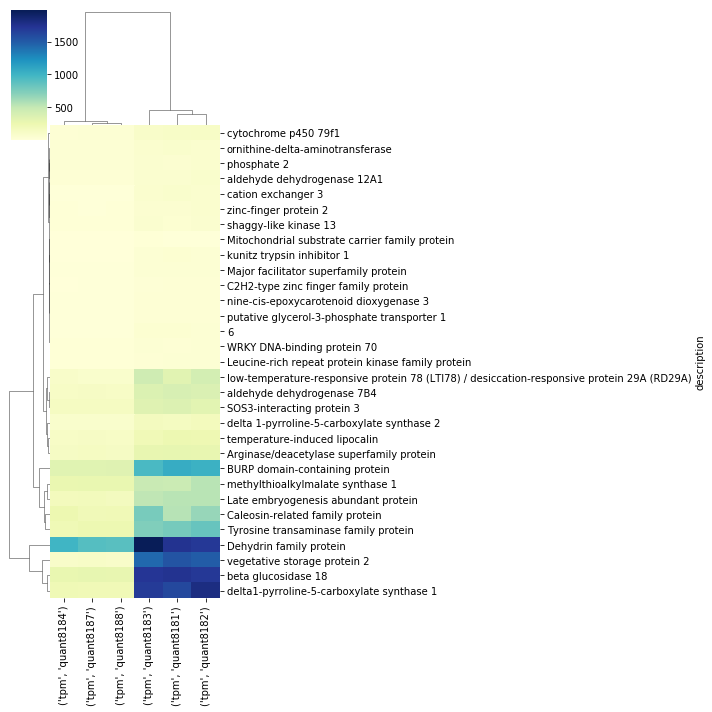

In [148]:
g=sns.clustermap(m, cmap='YlGnBu')

#연습문제 

1. 같은 분석을 'Molecular Functions'과 'Cellular Component'를 이용하여 수행해 보자. 
2. 'Overexpressed'대신 'Underexpressed'에 대해서도 수행해 보자. 
3. NaCl 대신 H2O2 처리군에 대해서도 분석을 수행해 보자. 
4. NaCl 처리군과 H2O2 처리군에서 공통적으로 발현되는 유전자와, 각각의 Stress 조건에서 발현되는 유전자의 목록을 찾아보자. 
